Library Import

In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile,BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit.algorithms.optimizers import SPSA
import pandas as pd
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer


# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
# service = QiskitRuntimeService(channel="ibm_quantum")
from pylab import cm
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, BasicAer, IBMQ, execute, Aer, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer

# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import cm
from sklearn import metrics

# QKT related
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel, TrainableFidelityQuantumKernel
# from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit.algorithms.state_fidelities import ComputeUncompute
# from qiskit.primitives import Sampler

# Additional imports
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from collections import Counter

In [4]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

Preparing the Dataset

In [5]:
df = pd.read_csv(r'200 EXAMPLES.csv')
ytrain= df.iloc[:,7]
Xtrain= df.iloc[:,1:7]
Xtrain

,Coolant temp,Fuel pressure,LOG(Engine rpm),LOG(Lub oil pressure),LOG(Coolant pressure),lub oil temp
0,-0.772790,0.344223,0.482768,-0.243775,0.243036,0.563408
1,-0.086326,-0.062279,-0.316501,-0.244287,0.517765,0.034793
2,-0.385653,-0.147072,0.213726,-0.628313,-0.312446,0.898516
3,0.490692,0.434899,-0.460128,-0.058842,-0.961579,0.445002
4,0.580827,0.158654,-0.119384,-0.074489,-0.187463,-0.559568
...,...,...,...,...,...,...
195,0.172962,-0.287470,0.507028,-0.450261,-0.991773,0.520044
196,0.538044,0.534762,0.783982,-0.667502,-0.003361,0.209038
197,0.139001,-0.308990,0.109317,-0.973335,-0.717331,0.987307
198,-0.692401,-0.287310,0.089582,-0.116380,-0.163690,0.428278


In [6]:
#To reduce training dataset size
Xtrain,Xtest , ytrain, ytest = train_test_split(Xtrain, ytrain,stratify=ytrain, test_size=0.9)

In [7]:
Xtrain

,Coolant temp,Fuel pressure,LOG(Engine rpm),LOG(Lub oil pressure),LOG(Coolant pressure),lub oil temp
22,0.151531,0.226702,-0.833181,0.630092,0.824422,0.891307
13,0.207256,0.427178,-0.343775,0.467497,0.579474,-0.430303
167,-0.035179,-0.555292,0.125013,0.452432,-0.451118,0.357374
110,0.885073,-0.747906,0.726721,0.404705,0.865740,-0.505224
160,0.927969,0.044799,0.430122,0.158480,0.314005,0.174249
197,0.139001,-0.308990,0.109317,-0.973335,-0.717331,0.987307
196,0.538044,0.534762,0.783982,-0.667502,-0.003361,0.209038
67,-0.139973,-0.365888,0.507028,-0.105248,0.534982,0.947880
195,0.172962,-0.287470,0.507028,-0.450261,-0.991773,0.520044
37,0.756924,-0.882167,0.190832,-0.745012,-0.346403,0.980518


In [8]:
ytrain

22     1
13     0
167    0
110    1
160    0
197    1
196    0
67     1
195    0
37     1
69     0
61     0
193    1
91     1
93     0
68     0
177    0
187    1
129    1
148    1
Name: Engine Condition, dtype: int64

Define the Quantum Feature Map


Figure(371.107x535.111)
Trainable parameters: θ, ['θ[0]']


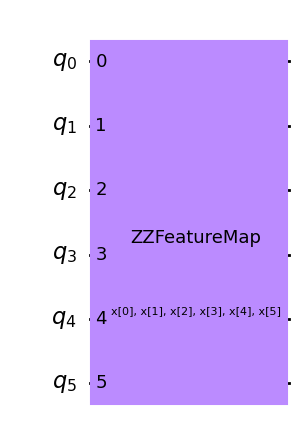

In [9]:
from qiskit.circuit.library import PauliFeatureMap,ZFeatureMap
from qiskit.visualization import circuit_drawer

# Define the parameter vector
training_params = ParameterVector("θ", 1)

# Define the quantum circuit with PauliFeatureMap
fm0 = QuantumCircuit(6)
for i in range(6):
    fm0.rx(training_params[0], i)

# Define the PauliFeatureMap


# Create the feature map, composed of the two circuits
# fm = fm0.compose(fm1)
fm=ZZFeatureMap(6, entanglement='linear')
# Print the circuit and trainable parameters
print(circuit_drawer(fm, output='mpl'))
print(f"Trainable parameters: {training_params}")
fm.draw(output="mpl")


In [10]:
qc=ZZFeatureMap(6, entanglement='circular')
print(transpile(qc,optimization_level=3).depth())

40


In [11]:
# Connecting with IBMQ
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

In [12]:

service.backends()

[<IBMBackend('ibmq_manila')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_stabilizer')>]

In [13]:
# Use the IBM quantum backend
backend = service.backend("ibmq_qasm_simulator")


In [14]:
# with (service=service, backend=backend):
#     sampler = Sampler()
#     fidelity = ComputeUncompute(sampler=sampler)
#     quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm)
#     qsvc = QSVC(quantum_kernel=quantum_kernel)
#     qsvc.fit(Xtrain, ytrain)

In [15]:
from qiskit_aer.noise import NoiseModel

noisy_backend = service.get_backend('ibmq_jakarta')
backend_noise_model = NoiseModel.from_backend(noisy_backend)

simulator = service.get_backend('ibmq_qasm_simulator')

options = Options()
options.resilience_level = 0
options.optimization_level = 0
options.simulator = {
    "noise_model": backend_noise_model
}
with Session(service=service, backend=simulator) as session:
    sampler = Sampler(session=session, options=options)
    fidelity = ComputeUncompute(sampler=sampler)
    quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm)
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(Xtrain, ytrain)
    # estimator = Estimator(session=session, options=options)
    # job = estimator.run(circuits=qc, observables=O)
    # print(job.result().values)

Fit and Test the Model

In [16]:
# # Use QSVC for classification
# qsvc = QSVC(quantum_kernel=optimized_kernel)

# # Fit the QSVC
# qsvc.fit(Xtrain, ytrain)

In [17]:
Xtest

,Coolant temp,Fuel pressure,LOG(Engine rpm),LOG(Lub oil pressure),LOG(Coolant pressure),lub oil temp
75,0.579481,-0.740318,-0.595958,-0.676475,0.060599,-0.249580
16,-0.219459,-0.738425,0.336653,0.452605,-0.273045,0.368403
100,0.742370,-0.863195,0.461819,-0.534936,-0.622740,-0.228794
198,-0.692401,-0.287310,0.089582,-0.116380,-0.163690,0.428278
7,0.230151,0.663693,-0.127879,0.938026,-0.274727,0.509296
...,...,...,...,...,...,...
131,-0.019669,-0.462957,0.749118,-0.877870,0.226956,0.301437
94,0.445968,-0.794743,0.475801,0.356789,0.032288,0.452775
97,0.283675,-0.023514,0.140628,-0.356208,0.476211,-0.277596
118,0.528152,-0.576108,-0.498322,0.175316,0.207793,-0.467063


In [19]:
Xtest.iloc[0:0+2,:]

,Coolant temp,Fuel pressure,LOG(Engine rpm),LOG(Lub oil pressure),LOG(Coolant pressure),lub oil temp
75,0.579481,-0.740318,-0.595958,-0.676475,0.060599,-0.249580
16,-0.219459,-0.738425,0.336653,0.452605,-0.273045,0.368403


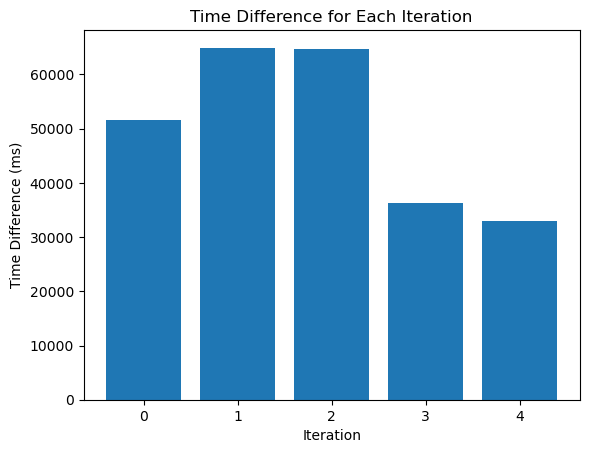

In [20]:
import time
import matplotlib.pyplot as plt



# Number of iterations
num_iterations = 5

# Arrays to store start and end times, and differences
start_times = []
end_times = []
differences = []

# Loop for 10 iterations
for i in range(num_iterations):
    # Start time of the iteration
    start_time = time.time()

    # Simulate model prediction
    ypred=qsvc.predict(Xtest.iloc[i:i+1,:])

    # End time of the iteration
    end_time = time.time()

    # Calculate time difference in milliseconds
    time_difference_ms = (end_time - start_time) * 1000

    # Append data to arrays
    start_times.append(start_time)
    end_times.append(end_time)
    differences.append(time_difference_ms)

# Plotting the bar graph
plt.bar(range(num_iterations), differences)
plt.xlabel('Iteration')
plt.ylabel('Time Difference (ms)')
plt.title('Time Difference for Each Iteration')
plt.show()


In [ ]:


# Predict the labels
labels_test = qsvc.predict(Xtest)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=ytest, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(ytest,labels_test))
print(classification_report(ytest,labels_test))

Visualize the Kernel Training Process

In [ ]:
# plot_data = cb_qkt.get_callback_data()  # callback data
# K = optimized_kernel.evaluate(Xtrain)  # kernel matrix evaluated on the training samples

# plt.rcParams["font.size"] = 20
# fig, ax = plt.subplots(1, 2, figsize=(14, 5))
# ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
# ax[0].set_xlabel("Iterations")
# ax[0].set_ylabel("Loss")
# ax[1].imshow(K, cmap=cm.get_cmap("bwr", 20))
# fig.tight_layout()
# plt.show()